# 06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

In [148]:
!nvidia-smi

Fri Aug 23 08:59:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce 840M            Off | 00000000:03:00.0 Off |                  N/A |
| N/A   49C    P8              N/A /  19W |      6MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Creating helper functions
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-22 09:15:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.01s   

2024-08-22 09:15:28 (1.01 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [9]:
import helper_functions
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves, compare_historys

In [10]:
# Getting dataset
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

In [11]:
#unzip_data('101_food_classes_10_percent.zip')

In [13]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/eggs_benedict'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250

In [16]:
import tensorflow as tf

In [237]:
train_dir='101_food_classes_10_percent/train'
test_dir='101_food_classes_10_percent/test'

train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                              label_mode='categorical',
                                                                              image_size=(224,224))

test_data_all=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224,224),
                                                                 shuffle=False)

print('It has been run')

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.
It has been run


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

- Create a ModelCheckpoint callback
- Create a data augmentation layer to build data augmentation right into the model
- Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
- Compile our model
- Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [238]:
# Create data augmentation layer
from tensorflow.keras import layers

data_augmentation=tf.keras.models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    #layers.Rescaling(1/255.) # it's not needed for EfficientNet models
], name='data_augmentation')

In [239]:
# Setup the base model and freeze its layers (this is for feature extraction)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# setum the model architecture with trainable top layers
inputs= tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
x= data_augmentation(inputs)
x= base_model(x, training=False)# put the base model in inference mode so weights which need to stay frozen, stay frozen
x= tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs= tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model= tf.keras.Model(inputs,outputs)


In [240]:
len(train_data_all_10_percent.class_names)

101

In [241]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_layer_13 False
rescaling_20 False
normalization_10 False
rescaling_21 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite Fals

In [242]:
train_data_all_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [243]:
data_augmentation.summary()

Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [244]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_20        │ (None, None,      │          0 │ input_layer_13[0… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_10    │ (None, None,      │          7 │ rescaling_20[0][… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_21        │ (None, None,      │          0 │ normalization_10… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_21[0][… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [245]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [246]:
1280*101+101

129381

In [247]:
# Create checkpoint
checkpoint_path='Checkpoints/1.weights.h5'
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor='val_accuracy',
                                                       save_best_only=True,
                                                       verbose=1)


In [248]:
# Compile
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# Fit
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                        epochs=5,
                                        validation_data=test_data_all,
                                        validation_steps=int(0.15 * len(test_data_all)),
                                        callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1312 - loss: 4.0627
Epoch 1: val_accuracy improved from -inf to 0.37262, saving model to Checkpoints/1.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.1315 - loss: 4.0607 - val_accuracy: 0.3726 - val_loss: 2.7992
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4251 - loss: 2.5783
Epoch 2: val_accuracy improved from 0.37262 to 0.45736, saving model to Checkpoints/1.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 661s 3s/step - accuracy: 0.4250 - loss: 2.5781 - val_accuracy: 0.4574 - val_loss: 2.1938
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5014 - loss: 2.1498
Epoch 3: val_accuracy improved from 0.45736 to 0.56515, saving model to Checkpoints/1.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.5014 - loss: 2.1497 - val_accuracy: 0.5651 - val_loss: 1.7892
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5393 - loss: 1.9280
Epoch 4: val_accuracy 

In [249]:
results_feature_extraction=model.evaluate(test_data_all)

790/790 ━━━━━━━━━━━━━━━━━━━━ 1384s 2s/step - accuracy: 0.5249 - loss: 1.8490


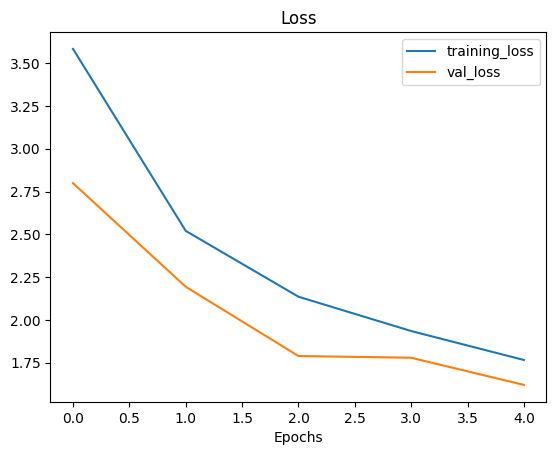

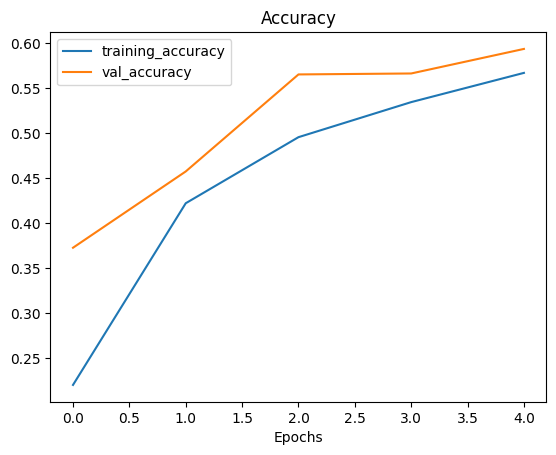

In [250]:
 plot_loss_curves(history_all_classes_10_percent)

>🤔 Question: What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [251]:
# Unfreeze the last 5 layers of the base model
for layer in base_model.layers[-5:]:
    layer.trainable=True

# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])


In [252]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [253]:
for i, layer in enumerate(model.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_layer_13 False
1 rescaling_20 False
2 normalization_10 False
3 rescaling_21 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_sq

In [254]:
history_all_classes_10_percent.epoch

[0, 1, 2, 3, 4]

In [255]:
# Fine-tunefor 5 more epochs
history_all_classes_10_percent_fine_tune= model.fit(train_data_all_10_percent,
                                                   epochs=10,
                                                   validation_data= test_data_all,
                                                   validation_steps= int(0.15 * len(test_data_all)),
                                                   initial_epoch=5)


Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 701s 3s/step - accuracy: 0.5786 - loss: 1.7917 - val_accuracy: 0.5114 - val_loss: 1.9169
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 679s 3s/step - accuracy: 0.6274 - loss: 1.5444 - val_accuracy: 0.5395 - val_loss: 1.7565
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 689s 3s/step - accuracy: 0.6508 - loss: 1.4397 - val_accuracy: 0.6208 - val_loss: 1.4998
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - accuracy: 0.6544 - loss: 1.3894 - val_accuracy: 0.5784 - val_loss: 1.6007
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.6881 - loss: 1.3045 - val_accuracy: 0.6409 - val_loss: 1.3824


In [256]:
results_fine_tune=model.evaluate(test_data_all)

790/790 ━━━━━━━━━━━━━━━━━━━━ 1374s 2s/step - accuracy: 0.5584 - loss: 1.6897


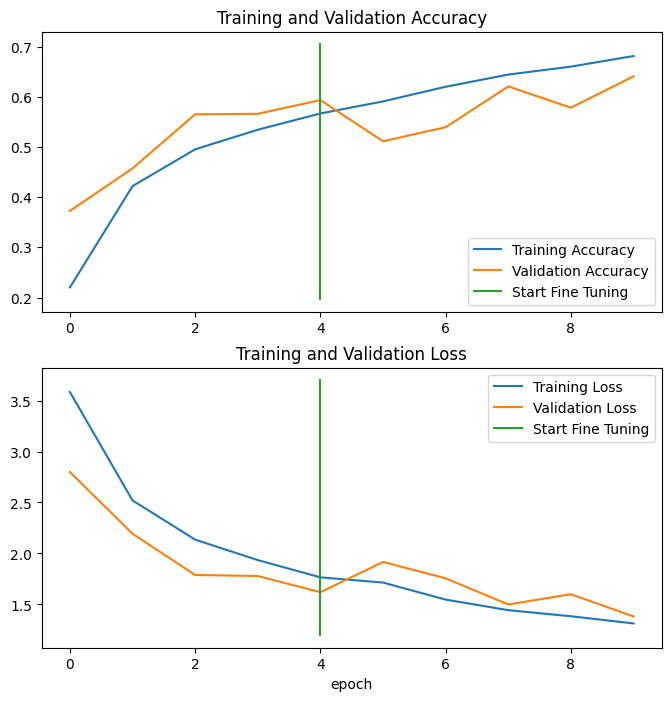

In [257]:
compare_historys(history_all_classes_10_percent,history_all_classes_10_percent_fine_tune)

In [258]:
history_all_classes_10_percent_fine_tune.epoch

[5, 6, 7, 8, 9]


## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere.

In [259]:
# save our fine-tunned model
model.save('saved_model/101_food_classes_10_percent_keras.keras')
#model.save('saved_model/101_food_classes_10_percent_h5.h5')
model.save('saved_model/101_food_classes_10_percent_unzipped', zipped=False)
model.save_weights('saved_model/101_food_classes_10_percent_weights.weights.h5')


In [260]:
loaded_model= tf.keras.models.load_model('saved_model/101_food_classes_10_percent_keras')

In [261]:
results_fine_tune_loaded_model= loaded_model.evaluate(test_data_all)

790/790 ━━━━━━━━━━━━━━━━━━━━ 1385s 2s/step - accuracy: 0.5413 - loss: 1.7885


## Making predictions with our trained model

In [262]:
preds_probs= model.predict(test_data_all, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 1392s 2s/step


In [263]:
len(preds_probs)

25250

In [264]:
preds_probs.shape

(25250, 101)

In [265]:
preds_probs[0]

array([3.0605963e-01, 1.6984479e-03, 1.9751090e-01, 5.8937616e-07,
       7.8623671e-06, 1.3071537e-05, 8.3227648e-04, 5.2325457e-05,
       2.8628830e-02, 5.2321341e-04, 1.9353278e-05, 1.5621570e-04,
       3.5449674e-03, 1.8981502e-05, 3.1261217e-02, 6.0570944e-04,
       9.2124646e-05, 2.4586425e-03, 6.6691742e-04, 2.0992942e-05,
       8.6778187e-04, 2.2020515e-04, 7.0357736e-04, 6.1812386e-04,
       1.1681346e-03, 1.3066690e-03, 3.1722820e-04, 2.8827582e-05,
       5.0317548e-02, 3.0864310e-03, 2.9857767e-05, 9.3028136e-04,
       1.3114993e-03, 3.3284454e-05, 7.3245326e-03, 8.5907210e-05,
       1.6262254e-03, 4.5376639e-03, 7.8031877e-03, 9.6221054e-05,
       1.1156448e-03, 2.0666148e-03, 1.2910936e-03, 3.2178421e-05,
       5.6287015e-05, 3.6350591e-04, 1.5310170e-03, 1.8743364e-04,
       1.5090196e-05, 5.7543656e-03, 1.3375332e-03, 5.6952846e-05,
       1.6690758e-01, 6.6609331e-03, 4.3918262e-05, 3.4746531e-02,
       1.3121936e-03, 4.9276738e-03, 2.3191011e-02, 5.6840145e

In [266]:
len(preds_probs)

25250

In [267]:
preds_probs[0].argmax()

0

In [268]:
tf.argmax(preds_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [269]:
test_data_all.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [270]:
preds_probs[0][43]

3.217842e-05

In [271]:
test_data_all.class_names[43]

'fried_calamari'

In [272]:
pred_classes=preds_probs.argmax(axis=1)

In [273]:
pred_classes.shape

(25250,)

In [274]:
pred_classes[:10]

array([ 0,  0,  0,  0,  8, 78, 29,  0, 85,  0])

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.


In [275]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data_all.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs

y_labels[:10] # look at the first 10 

2024-08-24 01:16:53.124491: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [276]:
len(y_labels)

25250

In [277]:
len(test_data_all)

790

In [278]:
790*32

25280

In [279]:
test_data_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [280]:
test_data_all.unbatch()

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(101,), dtype=tf.float32, name=None))>

In [284]:
import gc

In [285]:
gc.collect()

85099

Evaluating our model's predictions
One way to check that our model's predictions array (pred_classes) is in the same order as our test labels array (y_labels) is to find the accuracy score.



In [286]:
results_fine_tune_loaded_model

[1.6300994157791138, 0.5734257698059082]

In [287]:
from sklearn.metrics import accuracy_score

model_accuracy= accuracy_score(y_true=y_labels, y_pred=pred_classes)
model_accuracy

# This works correctly if we have set the shuffle to False when in test_data loading

0.5836435643564356

In [288]:
import numpy as np
np.isclose(results_fine_tune_loaded_model[1], model_accuracy)

False

## Let' get visual: making a confusion matrix

In [289]:
from helper_functions import make_confusion_matrix

In [290]:
class_names=test_data_all.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [291]:
# Our function needs a different name to sklearn's plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  
  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

In [292]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20,
                     savefig=True)

In [294]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [293]:
pred_classes[:10]

array([ 0,  0,  0,  0,  8, 78, 29,  0, 85,  0])

## Let's keep the evaluation train going, time for a classification report
Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called `classification_report`, let's try it out.

In [295]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,
                     y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.18      0.23       250
           1       0.50      0.70      0.59       250
           2       0.58      0.56      0.57       250
           3       0.74      0.52      0.61       250
           4       0.53      0.47      0.50       250
           5       0.40      0.36      0.38       250
           6       0.73      0.73      0.73       250
           7       0.88      0.70      0.78       250
           8       0.28      0.42      0.34       250
           9       0.39      0.60      0.47       250
          10       0.45      0.46      0.46       250
          11       0.63      0.62      0.63       250
          12       0.66      0.57      0.61       250
          13       0.49      0.55      0.52       250
          14       0.48      0.58      0.53       250
          15       0.41      0.31      0.35       250
          16       0.65      0.50      0.56       250
          17       0.38    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [296]:
# Get a dictionary of the classification report
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)

In [297]:
classification_report_dict

{'0': {'precision': 0.30612244897959184,
  'recall': 0.18,
  'f1-score': 0.22670025188916876,
  'support': 250.0},
 '1': {'precision': 0.5014245014245015,
  'recall': 0.704,
  'f1-score': 0.5856905158069884,
  'support': 250.0},
 '2': {'precision': 0.5791666666666667,
  'recall': 0.556,
  'f1-score': 0.5673469387755102,
  'support': 250.0},
 '3': {'precision': 0.7371428571428571,
  'recall': 0.516,
  'f1-score': 0.6070588235294118,
  'support': 250.0},
 '4': {'precision': 0.5294117647058824,
  'recall': 0.468,
  'f1-score': 0.4968152866242038,
  'support': 250.0},
 '5': {'precision': 0.3991031390134529,
  'recall': 0.356,
  'f1-score': 0.3763213530655391,
  'support': 250.0},
 '6': {'precision': 0.7349397590361446,
  'recall': 0.732,
  'f1-score': 0.7334669338677354,
  'support': 250.0},
 '7': {'precision': 0.8844221105527639,
  'recall': 0.704,
  'f1-score': 0.7839643652561247,
  'support': 250.0},
 '8': {'precision': 0.28191489361702127,
  'recall': 0.424,
  'f1-score': 0.33865814696

Let's plot all of our classes F1-score

In [298]:
classification_report_dict.keys()


dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', 'accuracy', 'macro avg', 'weighted avg'])

In [299]:
list(classification_report_dict.keys())[0]

'0'

In [300]:
list(classification_report_dict.values())[0]

{'precision': 0.30612244897959184,
 'recall': 0.18,
 'f1-score': 0.22670025188916876,
 'support': 250.0}

In [301]:
list(classification_report_dict.values())[0]['f1-score']

0.22670025188916876

In [302]:
f1_scores_dict={}

for key, value in classification_report_dict.items():
    if key== 'accuracy':
        break
    else:
        f1_scores_dict[class_names[int(key)]]= value['f1-score']

In [303]:
f1_scores_dict

{'apple_pie': 0.22670025188916876,
 'baby_back_ribs': 0.5856905158069884,
 'baklava': 0.5673469387755102,
 'beef_carpaccio': 0.6070588235294118,
 'beef_tartare': 0.4968152866242038,
 'beet_salad': 0.3763213530655391,
 'beignets': 0.7334669338677354,
 'bibimbap': 0.7839643652561247,
 'bread_pudding': 0.33865814696485624,
 'breakfast_burrito': 0.47468354430379744,
 'bruschetta': 0.45544554455445546,
 'caesar_salad': 0.6277665995975855,
 'cannoli': 0.6124197002141327,
 'caprese_salad': 0.5169811320754717,
 'carrot_cake': 0.5263157894736842,
 'ceviche': 0.35079726651480636,
 'cheese_plate': 0.5610859728506787,
 'cheesecake': 0.42105263157894735,
 'chicken_curry': 0.44356435643564357,
 'chicken_quesadilla': 0.5947136563876652,
 'chicken_wings': 0.7113594040968343,
 'chocolate_cake': 0.5309734513274337,
 'chocolate_mousse': 0.32418952618453867,
 'churros': 0.7428571428571429,
 'clam_chowder': 0.7109375,
 'club_sandwich': 0.6641074856046065,
 'crab_cakes': 0.38074398249452956,
 'creme_brulee'

In [304]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [305]:
import pandas as pd

f1_scores_df=pd.DataFrame({'class_names':f1_scores_dict.keys(),
                           'f1-score': f1_scores_dict.values()})

In [306]:
f1_scores_df[:10]

class_names  f1-score
0          apple_pie  0.226700
1     baby_back_ribs  0.585691
2            baklava  0.567347
3     beef_carpaccio  0.607059
4       beef_tartare  0.496815
5         beet_salad  0.376321
6           beignets  0.733467
7           bibimbap  0.783964
8      bread_pudding  0.338658
9  breakfast_burrito  0.474684

In [307]:
f1_scores_sorted= f1_scores_df.sort_values('f1-score', ascending=False)

In [308]:
f1_scores_sorted[:10]

class_names  f1-score
33            edamame  0.951456
63           macarons  0.863931
75                pho  0.829365
86            sashimi  0.810811
54  hot_and_sour_soup  0.801603
45      frozen_yogurt  0.798464
64          miso_soup  0.796905
32          dumplings  0.794677
51          guacamole  0.791897
88      seaweed_salad  0.786749

In [365]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(rect.get_x() + rect.get_width() + 0.03 , rect.get_y() + rect.get_height()/2.,
                '%.2f' % width,
                ha='center', va='center', color='black')


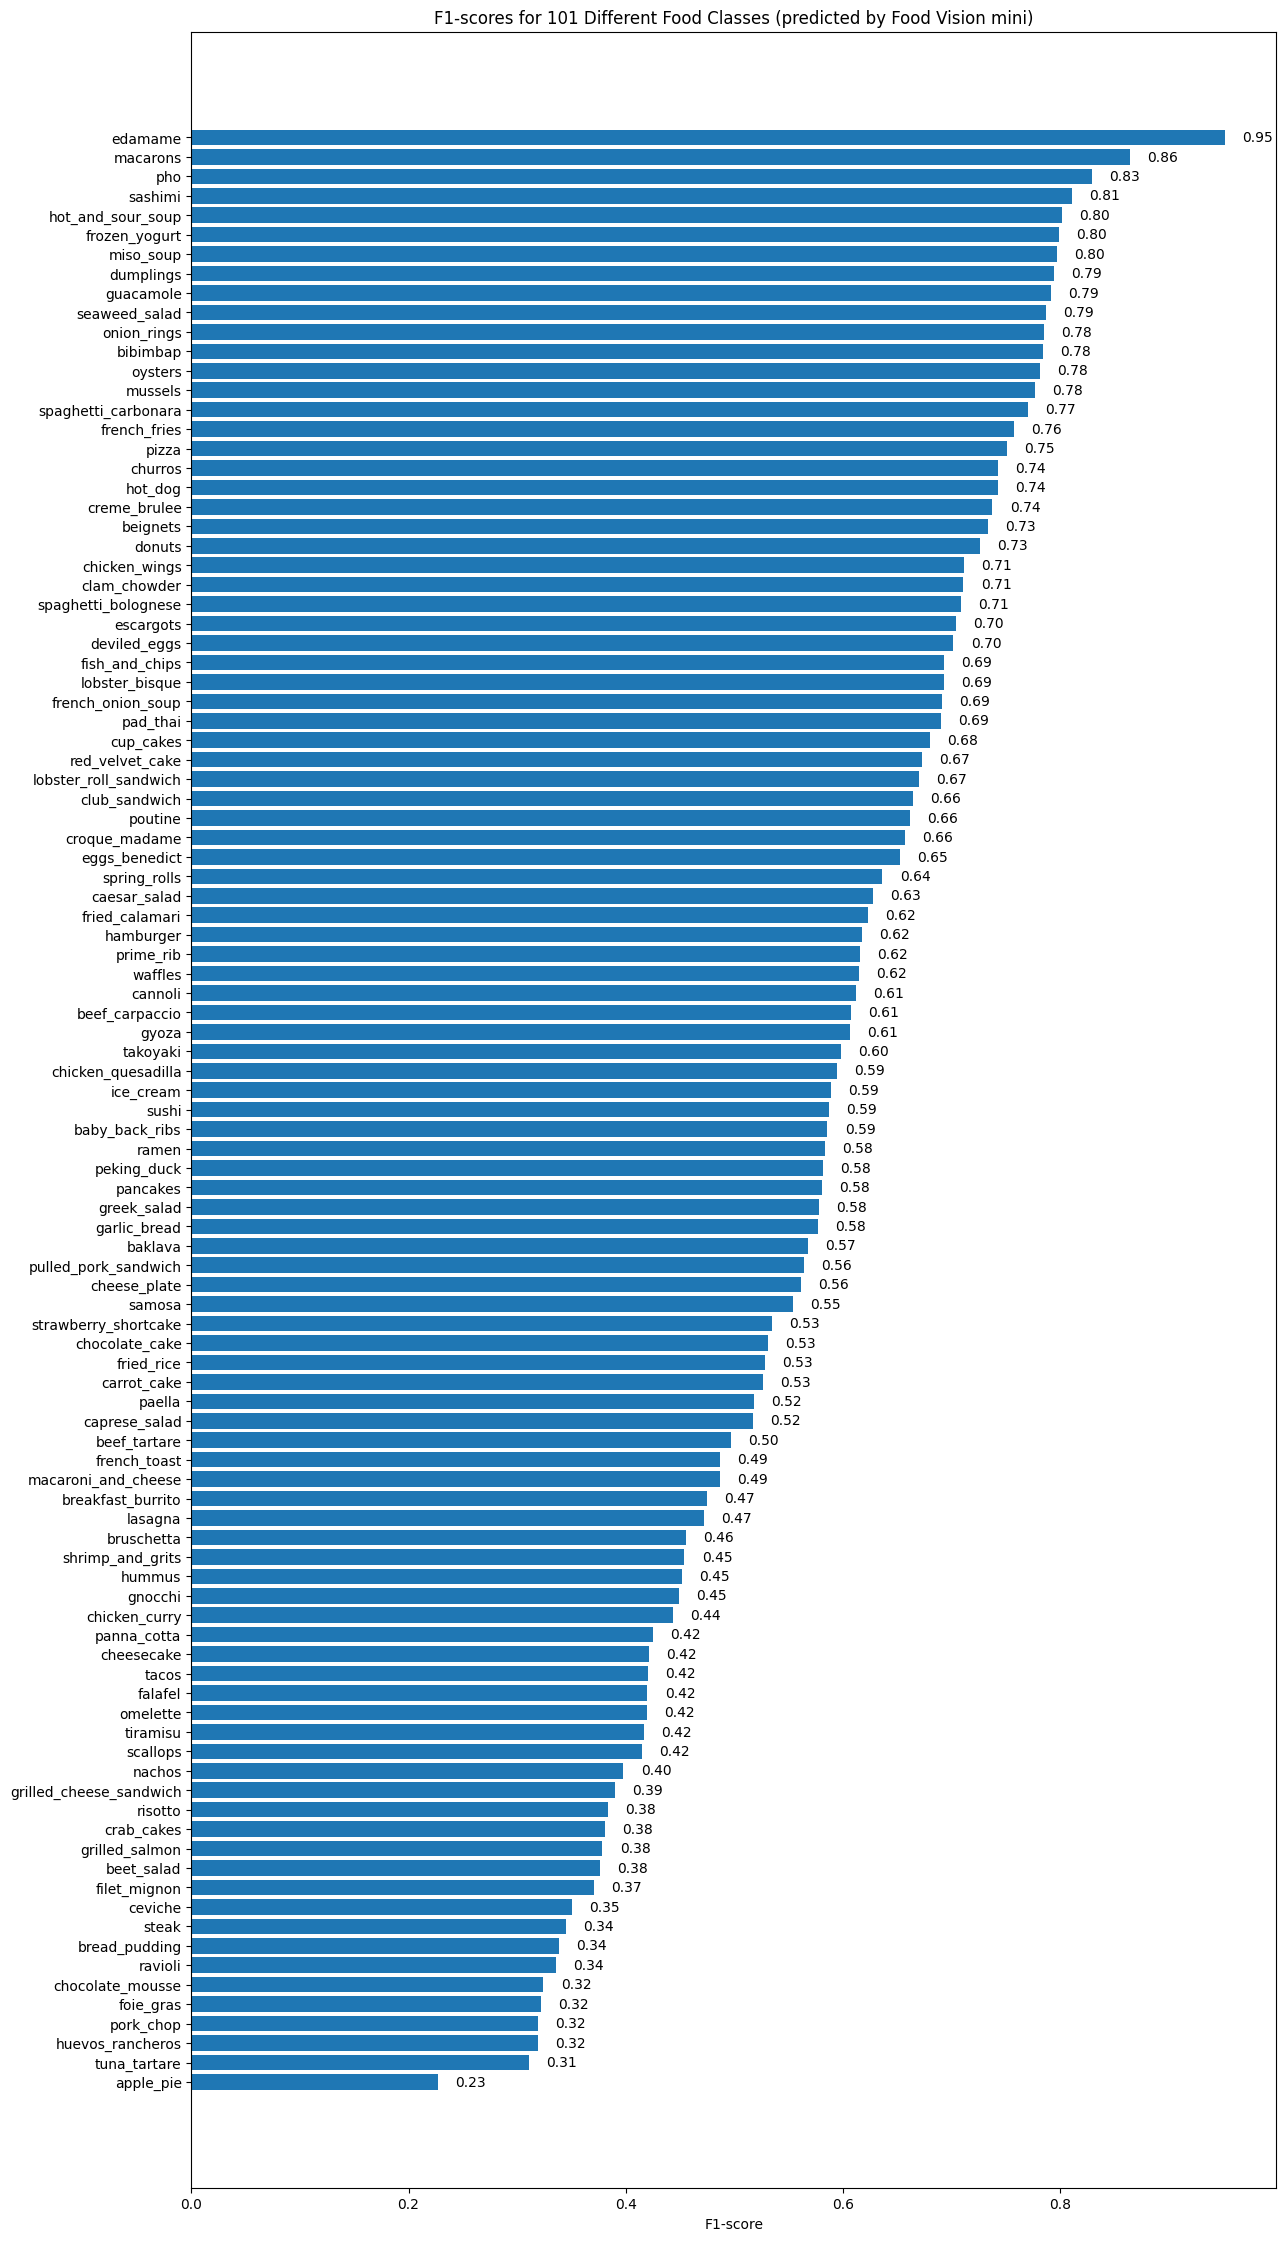

In [366]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(14,28))
scores= ax.barh(range(len(f1_scores_sorted)), f1_scores_sorted['f1-score'])
ax.invert_yaxis()
ax.set_xlabel('F1-score')
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.set_yticks(range(len(f1_scores_sorted)))
ax.set_yticklabels(f1_scores_sorted['class_names'])

autolabel(scores)

In [314]:
len(f1_scores_sorted)

101

In [325]:
f1_scores_sorted['f1-score']

33    0.951456
63    0.863931
75    0.829365
86    0.810811
54    0.801603
        ...   
39    0.322115
77    0.318966
56    0.318777
99    0.311111
0     0.226700
Name: f1-score, Length: 101, dtype: float64

In [369]:
f1_scores_sorted['f1-score'].values

array([0.95145631, 0.86393089, 0.82936508, 0.81081081, 0.80160321,
       0.79846449, 0.79690522, 0.79467681, 0.79189687, 0.78674948,
       0.78486056, 0.78396437, 0.78143133, 0.77712032, 0.77057793,
       0.75739645, 0.75088968, 0.74285714, 0.74275362, 0.73767258,
       0.73346693, 0.72589792, 0.7113594 , 0.7109375 , 0.70852018,
       0.70410367, 0.70175439, 0.69306931, 0.69281046, 0.69135802,
       0.68988391, 0.68041237, 0.6730038 , 0.66954644, 0.66410749,
       0.6618705 , 0.65724382, 0.65210084, 0.63636364, 0.6277666 ,
       0.62288136, 0.61770245, 0.61566485, 0.61510791, 0.6124197 ,
       0.60705882, 0.60618557, 0.5978022 , 0.59471366, 0.58874459,
       0.58711217, 0.58569052, 0.58333333, 0.58165548, 0.58089669,
       0.57748777, 0.57668712, 0.56734694, 0.56410256, 0.56108597,
       0.55395683, 0.53473684, 0.53097345, 0.52791878, 0.52631579,
       0.51813472, 0.51698113, 0.49681529, 0.48669202, 0.4866562 ,
       0.47468354, 0.47234043, 0.45544554, 0.45403377, 0.45147

>🛠 **Exercise:** Try visualizing some of the most poorly predicted classes (e.g. apple_pie, pork_chip), do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing predictions on test images
Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

- Read in a target image filepath using tf.io.read_file()
- Turn the image into a Tensor using tf.io.decode_image()
- Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
- Scale the image to get all of the pixel values between 0 & 1 (if necessary)
- Reshape images by tf.expand_dims(axis=0), this function adds an empty dimention at the first as a batch dimention in test data

In [483]:
# Create a function to load and prepare images for prediction
def load_and_prep_image(file_name, img_size=(224,224), rescale=True):
    img= tf.io.read_file(file_name)
    img= tf.io.decode_image(img, channels=3)
    img= tf.image.resize(img, size=img_size)
    
    if rescale==True:
        return img/255. # don't to rescale images for EfficientNet in TensorFlow
        #print(img.shape)
        
    return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:

- Load a few random images from the test dataset
- Make predictions on the loaded images
- Plot the original image(s) along with the model's predictions, prediction probability and truth label

101_food_classes_10_percent/test/club_sandwich/2054401.jpg
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
101_food_classes_10_percent/test/mussels/736371.jpg
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
101_food_classes_10_percent/test/lobster_bisque/2367056.jpg
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


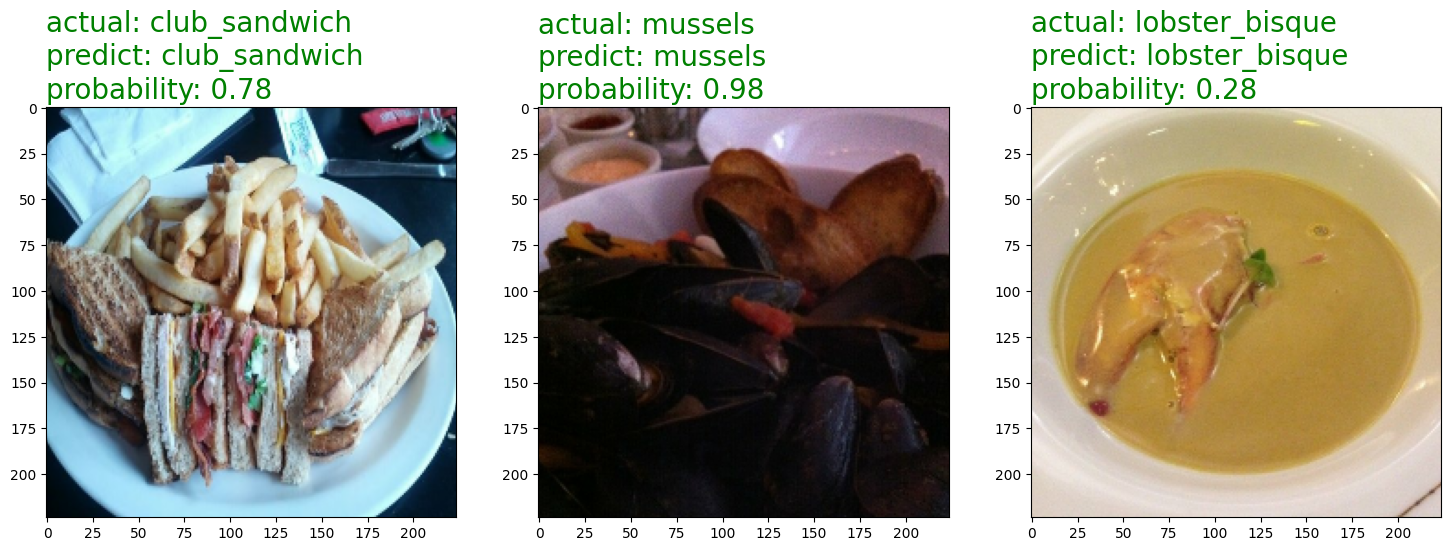

In [519]:
import os
import random
import numpy as np

plt.figure(figsize=(18,6))
for i in range(3):
    class_name= random.choice(class_names)
    files= os.listdir('101_food_classes_10_percent/test/' + class_name)
    image_name= random.choice(files)
    image_path= '101_food_classes_10_percent/test/' + class_name + '/' + image_name
    print(image_path)
    
    # Preprocess random image
    img= load_and_prep_image(image_path, rescale=False)
    #img= img/255.
    #print(img)
    print(img.shape)
    
    # Make prediction on random image
    pred_prob= model.predict(tf.expand_dims(img, axis=0))
    pred_class= class_names[pred_prob.argmax()]
    
    plt.subplot(1,3,i+1)
    plt.imshow(img/255)
    if class_name == pred_class:
        title_color='g'
    else:
        title_color='r'
        
    plt.title(f'actual: {class_name}\npredict: {pred_class}\nprobability: {pred_prob.max():.2f}',
              c=title_color, loc='left', fontsize=20)

In [404]:
class_name=random.choice(class_names)
class_name

'fried_calamari'

In [405]:
file_name=os.listdir('101_food_classes_10_percent/test/' + class_name)
file_name

['3667448.jpg',
 '822655.jpg',
 '1652929.jpg',
 '1052932.jpg',
 '3674776.jpg',
 '3246490.jpg',
 '1580146.jpg',
 '2567172.jpg',
 '693510.jpg',
 '2117581.jpg',
 '877971.jpg',
 '2005964.jpg',
 '1123519.jpg',
 '1787819.jpg',
 '1473557.jpg',
 '3671602.jpg',
 '3647458.jpg',
 '875794.jpg',
 '3319039.jpg',
 '679359.jpg',
 '1868403.jpg',
 '3083692.jpg',
 '185035.jpg',
 '974936.jpg',
 '756355.jpg',
 '2244961.jpg',
 '174394.jpg',
 '3550738.jpg',
 '1437967.jpg',
 '1851132.jpg',
 '2259961.jpg',
 '3629645.jpg',
 '2178804.jpg',
 '1650785.jpg',
 '2796106.jpg',
 '3024331.jpg',
 '1462214.jpg',
 '1471079.jpg',
 '1963748.jpg',
 '936686.jpg',
 '64144.jpg',
 '2246730.jpg',
 '1642092.jpg',
 '2625429.jpg',
 '1460581.jpg',
 '3890509.jpg',
 '1016491.jpg',
 '2069967.jpg',
 '2262574.jpg',
 '2292883.jpg',
 '1796439.jpg',
 '1376431.jpg',
 '854958.jpg',
 '695981.jpg',
 '2818834.jpg',
 '1499526.jpg',
 '2007282.jpg',
 '491868.jpg',
 '3212093.jpg',
 '136329.jpg',
 '2009121.jpg',
 '2351114.jpg',
 '1389368.jpg',
 '457374

In [408]:
random.choice(files_name)

'1276764.jpg'

In [455]:
a= a/255.

In [456]:
a

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.9857143 , 0.99355745, 0.9386555 ],
         [0.98179275, 0.9896359 , 0.9347339 ],
         [0.9876951 , 0.99553823, 0.9406363 ],
         ...,
         [0.8731292 , 0.88713497, 0.8291517 ],
         [0.8499599 , 0.8774109 , 0.8146658 ],
         [0.8488996 , 0.87635064, 0.8136055 ]],

        [[0.97815126, 0.9859944 , 0.93109244],
         [0.9767307 , 0.98457384, 0.9296719 ],
         [0.9806122 , 0.98845536, 0.9335534 ],
         ...,
         [0.8794917 , 0.89349747, 0.8355142 ],
         [0.8666467 , 0.8940977 , 0.8313526 ],
         [0.8676872 , 0.8951382 , 0.8323931 ]],

        [[0.9778712 , 0.9857143 , 0.93081236],
         [0.9764706 , 0.9843137 , 0.92941177],
         [0.9810524 , 0.98889554, 0.9339936 ],
         ...,
         [0.88311297, 0.89711875, 0.83913547],
         [0.86962795, 0.89707893, 0.83433384],
         [0.87699074, 0.9044417 , 0.8416966 ]],

        ...,

        [[0.8367148 , 0.8092638 , 

## Finding the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:

- Get all of the image file paths in the test dataset using list_files() method
- Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
- Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
- Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
- Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [525]:
# Get all of the image file paths in the test dataset
filepaths=[]

for filepath in test_data_all.list_files(file_pattern='101_food_classes_10_percent/test/*/*.jpg', 
                                         shuffle=False):
    filepaths.append(filepath.numpy())
    
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [526]:
len(filepaths)

25250

In [548]:
# Create a DataFrame of different parameters for each of our test images
import pandas as pd

pred_df=pd.DataFrame({'img_path': filepaths,
                     'y_true': y_labels,
                     'y_pred': pred_classes,
                     'pred_conf': preds_probs.max(axis=1),
                     'y_true_class_name': [class_names[i] for i in y_labels],
                     'y_pred_class_name': [class_names[i]for i in pred_classes]})



In [553]:
pred_df[:20]

img_path  y_true  y_pred  \
0   b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1   b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2   b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3   b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4   b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
5   b'101_food_classes_10_percent/test/apple_pie/1...       0      78   
6   b'101_food_classes_10_percent/test/apple_pie/1...       0      29   
7   b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
8   b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
9   b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
10  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
11  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
12  b'101_food_classes_10_percent/test/apple_pie/1...       0      43   
13  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
14  b'101_food_classes_10_percent/test/apple_pie/1...       0      42   
15  b'101_food_classes_10_percent/test/apple_pie/1...       0      26   
16  b'101_food_classes_10_percent/test/apple_pie/1...       0      34   
17  b'101_food_classes_10_percent/test/apple_pie/1...       0      58   
18  b'101_food_classes_10_percent/test/apple_pie/1...       0      57   
19  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

    pred_conf y_true_class_name y_pred_class_name  
0    0.306060         apple_pie         apple_pie  
1    0.760944         apple_pie         apple_pie  
2    0.333700         apple_pie         apple_pie  
3    0.155957         apple_pie         apple_pie  
4    0.568120         apple_pie     bread_pudding  
5    0.922173         apple_pie           poutine  
6    0.783239         apple_pie         cup_cakes  
7    0.494598         apple_pie         apple_pie  
8    0.234550         apple_pie            samosa  
9    0.428704         apple_pie         apple_pie  
10   0.619271         apple_pie         apple_pie  
11   0.222248         apple_pie            samosa  
12   0.287023         apple_pie    fried_calamari  
13   0.291714         apple_pie     bread_pudding  
14   0.178459         apple_pie      french_toast  
15   0.125254         apple_pie        crab_cakes  
16   0.350879         apple_pie     eggs_benedict  
17   0.308308         apple_pie         ice_cream  
18   0.205413         apple_pie            hummus  
19   0.616145         apple_pie     bread_pudding

In [530]:
len(pred_classes)

25250

In [531]:
len(y_labels)

25250

In [538]:
len(preds_probs)

25250

In [545]:
[class_names[i] for i in range(10)]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [554]:
# Find out in our DataFrame which predictions are wrong

pred_df['pred_correct']= pred_df['y_true']==pred_df['y_pred']
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100     100   
25247  b'101_food_classes_10_percent/test/waffles/961...     100      56   
25248  b'101_food_classes_10_percent/test/waffles/970...     100     100   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_class_name y_pred_class_name  pred_correct  
0       0.306060         apple_pie         apple_pie          True  
1       0.760944         apple_pie         apple_pie          True  
2       0.333700         apple_pie         apple_pie          True  
3       0.155957         apple_pie         apple_pie          True  
4       0.568120         apple_pie     bread_pudding         False  
...          ...               ...               ...           ...  
25245   0.976621           waffles           waffles          True  
25246   0.967714           waffles           waffles          True  
25247   0.574028           waffles  huevos_rancheros         False  
25248   0.414070           waffles           waffles          True  
25249   0.517222           waffles           waffles          True  

[25250 rows x 7 columns]

In [563]:
# Sort our DataFrame to have most wrong predictions at the top
pred_df_top_100_wrong= pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
pred_df_top_100_wrong

img_path  y_true  y_pred  \
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
17816  b'101_food_classes_10_percent/test/paella/1762...      71      70   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
...                                                  ...     ...     ...   
3101   b'101_food_classes_10_percent/test/cannoli/235...      12      29   
21148  b'101_food_classes_10_percent/test/risotto/291...      84      62   
11063  b'101_food_classes_10_percent/test/fried_rice/...      44      62   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
11974  b'101_food_classes_10_percent/test/gnocchi/782...      47      35   

       pred_conf     y_true_class_name    y_pred_class_name  pred_correct  
23631   0.995634  strawberry_shortcake      red_velvet_cake         False  
23797   0.993919                 sushi              sashimi         False  
17816   0.993092                paella             pad_thai         False  
15826   0.992449              macarons            cup_cakes         False  
18001   0.991876              pancakes             omelette         False  
...          ...                   ...                  ...           ...  
3101    0.932690               cannoli            cup_cakes         False  
21148   0.932111               risotto  macaroni_and_cheese         False  
11063   0.931704            fried_rice  macaroni_and_cheese         False  
8794    0.931220             escargots    french_onion_soup         False  
11974   0.930160               gnocchi            escargots         False  

[100 rows x 7 columns]

In [564]:
len(pred_df_top_100_wrong)

100

In [569]:
pred_df_top_100_wrong.head(100)

img_path  y_true  y_pred  \
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
17816  b'101_food_classes_10_percent/test/paella/1762...      71      70   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
...                                                  ...     ...     ...   
3101   b'101_food_classes_10_percent/test/cannoli/235...      12      29   
21148  b'101_food_classes_10_percent/test/risotto/291...      84      62   
11063  b'101_food_classes_10_percent/test/fried_rice/...      44      62   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
11974  b'101_food_classes_10_percent/test/gnocchi/782...      47      35   

       pred_conf     y_true_class_name    y_pred_class_name  pred_correct  
23631   0.995634  strawberry_shortcake      red_velvet_cake         False  
23797   0.993919                 sushi              sashimi         False  
17816   0.993092                paella             pad_thai         False  
15826   0.992449              macarons            cup_cakes         False  
18001   0.991876              pancakes             omelette         False  
...          ...                   ...                  ...           ...  
3101    0.932690               cannoli            cup_cakes         False  
21148   0.932111               risotto  macaroni_and_cheese         False  
11063   0.931704            fried_rice  macaroni_and_cheese         False  
8794    0.931220             escargots    french_onion_soup         False  
11974   0.930160               gnocchi            escargots         False  

[100 rows x 7 columns]

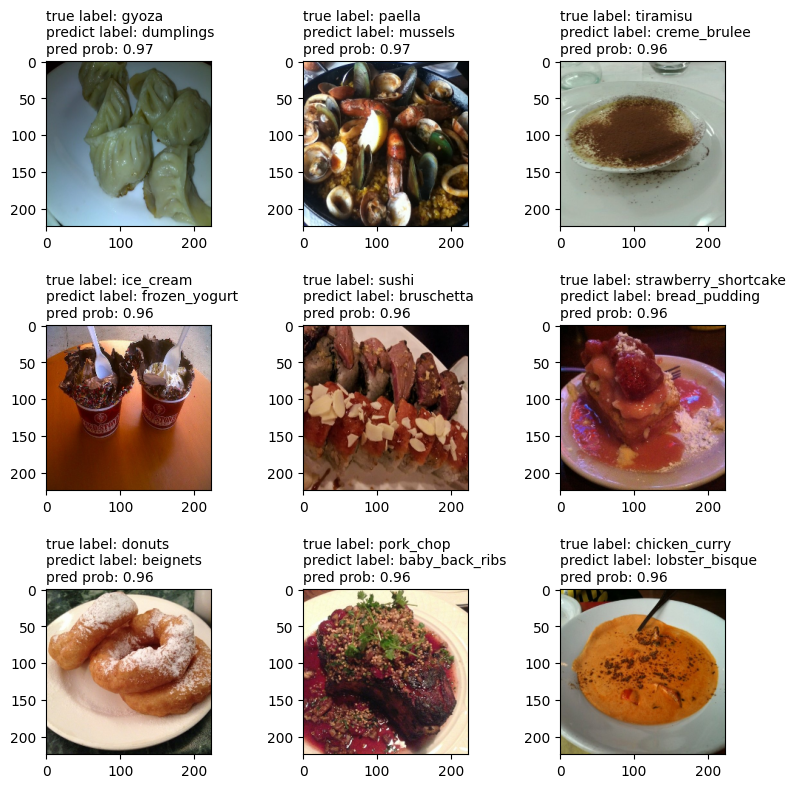

In [647]:
# Visualize the test data samples which have the wrong prediction but highest pred probability
start_index=30
number_of_images=9

plt.figure(figsize=(9,9))
#plt.subplots(number_of_images)
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i, row in enumerate(pred_df_top_100_wrong[start_index : start_index+number_of_images].itertuples()):
    plt.subplot(3,3,i+1)
    img= load_and_prep_image(row[1], rescale=False)
    
    #print(row)
    #print()
    
    _, _, _, _, pred_prob, y_true_class_name, y_pred_class_name, _ = row 
    
    plt.imshow(img/255.)
    plt.title(f'true label: {y_true_class_name}\n'
              f'predict label: {y_pred_class_name}\n'
              f'pred prob: {pred_prob:.2f}',
             loc='left', fontsize=10)

In [567]:
pred_df_top_100_wrong.index

Index([23631, 23797, 17816, 15826, 18001, 10847, 21216, 22606,    22,   920,
       11024, 25166, 14062, 15359, 14300,  8767, 12487, 11097, 14482, 22044,
        9073, 10947, 19521,   722, 14191, 18325,   582, 22684, 22511, 14697,
       13112, 17995, 24740, 14517, 23886, 23740,  7858, 19374,  4737, 10880,
        3159, 22095,   191,  7477,  5596, 24440,  5530, 22661, 10854, 14889,
         821,  9756, 13144,  5849,  5829,  1041, 17302, 10741, 18935, 14552,
        4660, 12322,  5652, 16209, 14631, 21400, 17897,   717, 18510, 11146,
       11642, 23283, 21810, 19899, 10877, 23935,  9184, 13207, 10289, 22728,
       23267,  5657, 19685, 22635, 15613,  1591, 17034,    60, 24946, 19713,
       23823, 14599, 10329,  3536, 15700,  3101, 21148, 11063,  8794, 11974],
      dtype='int64')

In [582]:
pred_df_top_100_wrong['img_path']

23631    b'101_food_classes_10_percent/test/strawberry_...
23797    b'101_food_classes_10_percent/test/sushi/16593...
17816    b'101_food_classes_10_percent/test/paella/1762...
15826    b'101_food_classes_10_percent/test/macarons/19...
18001    b'101_food_classes_10_percent/test/pancakes/10...
                               ...                        
3101     b'101_food_classes_10_percent/test/cannoli/235...
21148    b'101_food_classes_10_percent/test/risotto/291...
11063    b'101_food_classes_10_percent/test/fried_rice/...
8794     b'101_food_classes_10_percent/test/escargots/1...
11974    b'101_food_classes_10_percent/test/gnocchi/782...
Name: img_path, Length: 100, dtype: object

In [636]:
17//3


5

In [637]:
17//5

3

## Test out the big dog model on our own custom images

In [678]:
# Get the custom food images filepaths
custom_food_images= ['custom_food_images/' + image_path for image_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


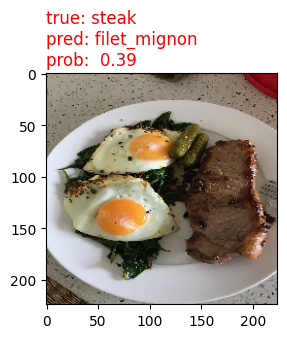

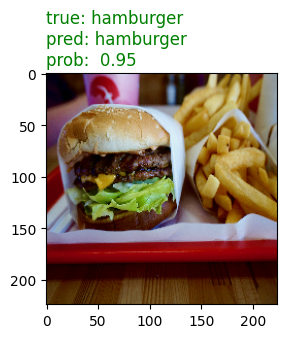

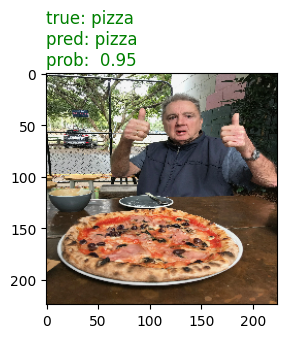

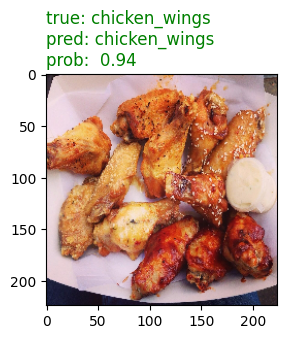

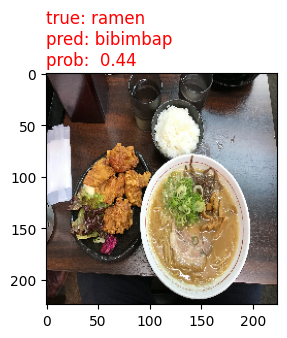

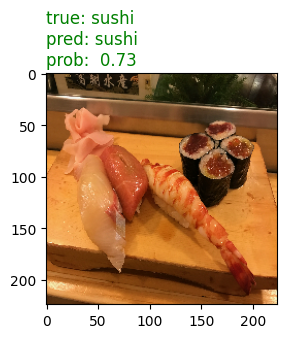

In [682]:
# Make predictions on and plot custom food images
for img in custom_food_images:
    true_label= img.split('/')[1].split('.')[0]
    
    img=load_and_prep_image(img, rescale=False) # don't need to scale for our EfficientNetB0 model
    pred_prob= model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
    pred_class= class_names[pred_prob.argmax()] # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
    
    if true_label==pred_class:
        title_color='g'
    else:
        title_color='red'
    
    plt.figure(figsize=(3,3))
    plt.imshow(img/255.)
    plt.title(f'true: {true_label}\npred: {pred_class}\nprob: {pred_prob.max(): .2f}', 
              loc='left', c=title_color)

In [660]:
custom_food_images[0].split('/')[1].split('.')[0]

'steak'

In [685]:
results_fine_tune

[1.5767138004302979, 0.5836435556411743]

In [683]:
results_feature_extraction

[1.7657808065414429, 0.5429307222366333]

In [684]:
results_fine_tune_loaded_model

[1.6300994157791138, 0.5734257698059082]

In [689]:
model.save('final_saved_model.keras')